In [128]:
import numpy as np
import scipy
import torch
from matplotlib import pyplot as plt
from matplotlib import transforms as tr
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable 
import control
from control import matlab
from matplotlib import cm

np.random.seed(0)
dev = "cpu"  
device = torch.device(dev) 

In [22]:
sysA = np.array([0.9983])
#sysA = 0.99
sysB = np.array([[0.005]])
sysC = np.array([0.3333])
sysD = 0
#print(np.linalg.eig(sysA))
kp = 10.0
ki = 10.0
kd = 0.0
Tf = 0.01

In [82]:
T = 2000
refs = np.zeros((30,T))

randval = 0
np.random.seed(0)

for i in range(30):
  refs[i,0:300] = 0
  randval = 8*np.random.rand()-4.0
  if randval>0 and randval<2:
    randval = 2
  if randval<0 and randval>-2:
    randval = -2
  refs[i,300:] = randval

In [92]:
ref = refs[8,:]
ysat = np.zeros((T,))
uvalssat = np.zeros((T,))
xcont = 0
u = 0
D = 0
ad = Tf/(Tf+0.01)
bd = kd/(Tf+0.01)
noise = 0.01*np.random.randn(T,1)

x0 = np.zeros((1,1))
x = x0
for i in range(T):
   ysat[i] = np.dot(sysC,x)+np.dot(sysD,u)+noise[i]
   xcont = xcont+ki*(ref[i]-ysat[i])
   if(i>0):
     D = ad*D-bd*(ysat[i]-ysat[i-1])  
     u = 0.01*xcont+kp*(ref[i]-ysat[i])+D
   if(u>10.0):
     u=10.0
   elif(u<-10.0):
     u=-10.0
   uvalssat[i] = u;
   x = np.dot(sysA,x)+np.dot(sysB,u);

ynosat = np.zeros((T,))
uvalsnosat = np.zeros((T,))
xcont = 0;
u = 0;
x = x0
D = 0

for i in range(T):
   ynosat[i] = np.dot(sysC,x)+np.dot(sysD,u)+noise[i]
   xcont = xcont+(ref[i]-ynosat[i])
   if(i>0):
     D = ad*D-bd*(ynosat[i]-ynosat[i-1])  
     u = 0.01*ki*xcont+kp*(ref[i]-ynosat[i])+D 
   uvalsnosat[i] = u;
   x = np.dot(sysA,x)+np.dot(sysB,u);

ybackc = np.zeros((T,))
uvalsbackc = np.zeros((T,))
xcont = 0
u = 0
ucmd = 0
D = 0
ad = Tf/(Tf+0.01)
bd = kd/(Tf+0.01)
back = 0.5

x = x0
for i in range(T):
   ybackc[i] = np.dot(sysC,x)+np.dot(sysD,u)+noise[i]
   xcont = xcont+ki*(ref[i]-ybackc[i])+back*(u-ucmd)
   if(i>0):
     D = ad*D-bd*(ybackc[i]-ybackc[i-1])  
     ucmd = 0.01*xcont+kp*(ref[i]-ybackc[i])+D
   if(ucmd>10.0):
     u=10.0
   elif(ucmd<-10.0):
     u=-10.0
   else:
     u = ucmd
   uvalsbackc[i] = u;
   x = np.dot(sysA,x)+np.dot(sysB,u);

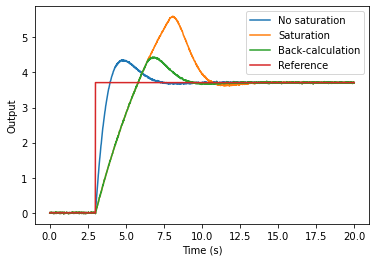

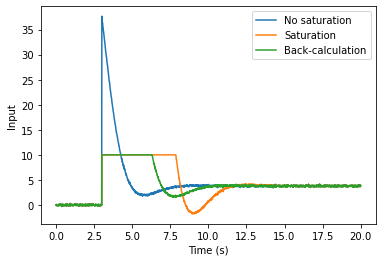

In [93]:
plt.figure
plt.plot(0.01*np.arange(T),ynosat)
plt.plot(0.01*np.arange(T),ysat)
plt.plot(0.01*np.arange(T),ybackc)
plt.plot(0.01*np.arange(T),ref)
plt.xlabel("Time (s)")
plt.ylabel("Output")
plt.legend(["No saturation","Saturation","Back-calculation","Reference"])
plt.show()

plt.figure
plt.plot(0.01*np.arange(T),uvalsnosat)
plt.plot(0.01*np.arange(T),uvalssat)
plt.plot(0.01*np.arange(T),uvalsbackc)
plt.xlabel("Time (s)")
plt.ylabel("Input")
plt.legend(["No saturation","Saturation","Back-calculation"])
plt.show()

In [94]:
class neuralPID(torch.nn.Module):
   def __init__(self):
    super(neuralPID, self).__init__()
    torch.manual_seed(2)
    self.kplayer1 = torch.nn.Linear(2,2)
    self.kplayer2 = torch.nn.Linear(2,1)
    self.kilayer1 = torch.nn.Linear(2,2)
    self.kilayer2 = torch.nn.Linear(2,1)
    self.backlayer1 = torch.nn.Linear(2,2)
    self.backlayer2 = torch.nn.Linear(2,1)
  
   def forward(self,x):
    sigmoid = torch.nn.Tanh()
    kp = self.kplayer2(sigmoid(self.kplayer1(x)))
    ki = self.kilayer2(sigmoid(self.kilayer1(x)))
    back = self.backlayer2(sigmoid(self.backlayer1(x)))
    #kd = torch.clamp(kd,0,400)
    #kp = torch.clamp(kp,0,400)
    #ki = torch.clamp(ki,0,400)
    return kp,ki,back

In [95]:
Tft = torch.tensor(Tf,requires_grad=True)
kpit = torch.tensor(kp,requires_grad=False)
kiit = torch.tensor(ki,requires_grad=False)
#kdit = torch.tensor(kd,requires_grad=False)
backit = torch.tensor(back,requires_grad=False)

systA = torch.tensor(sysA,requires_grad=False)
systB = torch.tensor(sysB,requires_grad=False)
systC = torch.tensor(sysC,requires_grad=False)
systD = torch.tensor(sysD,requires_grad=False)

In [96]:
costinit = np.zeros((30,))
costinitback = np.zeros((30,))

yinit = np.zeros((30,T))
uinit = np.zeros((30,T))

yinitback = np.zeros((30,T))
uinitback = np.zeros((30,T))

Tft = torch.tensor(Tf,requires_grad=True)
kpit = torch.tensor(kp,requires_grad=False)
kiit = torch.tensor(ki,requires_grad=False)
kdit = torch.tensor(kd,requires_grad=False)
backit = torch.tensor(back,requires_grad=False)

systA = torch.tensor(sysA,requires_grad=False)
systB = torch.tensor(sysB,requires_grad=False)
systC = torch.tensor(sysC,requires_grad=False)
systD = torch.tensor(sysD,requires_grad=False)

for iters in range(0,30):
  ref = refs[iters,:]
  reft = torch.tensor(ref)
  noise = 0.01*torch.randn(T,1)

  xcont = torch.tensor([0.0],requires_grad=True)
  x = torch.tensor([[0.0]],requires_grad=True)  
  u = torch.tensor([0.0],requires_grad=True)
  cost = torch.tensor([0.0],requires_grad=True)
  yt = torch.tensor([0.0],requires_grad=True)
  D  = torch.tensor([0.0],requires_grad=False)
  #torch.clamp(Tft,0.1,0.1)
  ad = torch.div(Tft,(Tft+0.01))
  
  for t in range(T):
    yold = yt
    yt = torch.matmul(systC.float(),x)+noise[t];
    yinit[iters,t] = yt.clone().detach().numpy()
    #print(yt)
    #error = torch.tensor(reft[t]-yt,requires_grad=False)
    err = ref[t]-yt
    xcont = xcont+err
    if(t>0):
       #print(t,kpt,kit,kdt)
       #break;
       bd = torch.div(kdit,(Tft+0.01))
       D = ad*D-bd*(yt-yold);  
       ucmd = (0.01*kiit*xcont+kpit*(ref[t]-yt)+D)
       u = torch.clamp(ucmd,-10.0,10.0)
    uinit[iters,t] = u.clone().detach().numpy()
    x = torch.matmul(systA.float(),x)+systB.float()*u;
    cost = cost+(reft[t]-yt)**2
  costinit[iters] = cost.detach().numpy()

  xcont = torch.tensor([0.0],requires_grad=True)
  x = torch.tensor([[0.0]],requires_grad=True)  
  u = torch.tensor([0.0],requires_grad=True)
  cost = torch.tensor([0.0],requires_grad=True)
  yt = torch.tensor([0.0],requires_grad=True)
  D  = torch.tensor([0.0],requires_grad=False)
  #torch.clamp(Tft,0.1,0.1)
  ad = torch.div(Tft,(Tft+0.01))
  
  for t in range(T):
    yold = yt
    yt = torch.matmul(systC.float(),x)+noise[t];
    yinitback[iters,t] = yt.clone().detach().numpy()
    #print(yt)
    #error = torch.tensor(reft[t]-yt,requires_grad=False)
    err = ref[t]-yt
    xcont = xcont+kiit*err+backit*(u-ucmd)
    if(t>0):
       #print(t,kpt,kit,kdt)
       #break;
       bd = torch.div(kdit,(Tft+0.01))
       D = ad*D-bd*(yt-yold);  
       ucmd = (0.01*xcont+kpit*(ref[t]-yt)+D)
       u = torch.clamp(ucmd,-10.0,10.0)
    uinitback[iters,t] = u.clone().detach().numpy()
    x = torch.matmul(systA.float(),x)+systB.float()*u;
    cost = cost+(reft[t]-yt)**2
  costinitback[iters] = cost.detach().numpy()


[ 225.64434814  225.44944763  225.82962036  225.60957336  224.36131287
  225.01365662  224.7101593  1007.21612549 1742.90991211  225.06677246
  378.80252075  225.5670166   226.14265442 1321.34106445 1355.52258301
 1197.53527832 1947.09448242  587.81591797  322.33688354  835.83447266
 1929.06774902  411.74472046  224.76664734  332.3374939   927.54003906
  225.19924927  740.15783691 1523.92895508  225.62768555  225.32455444]
[ 193.63157654  193.45959473  193.77661133  193.57797241  192.5065155
  193.04463196  192.87654114  731.41290283 1209.34216309  193.12869263
  305.61535645  193.52293396  194.01249695  936.75067139  958.8548584
  856.09008789 1340.9029541   451.12738037  265.10076904  618.19067383
 1329.30493164  328.98620605  192.90313721  272.33795166  679.0045166
  193.23005676  554.20916748 1067.95446777  193.58447266  193.30574036]


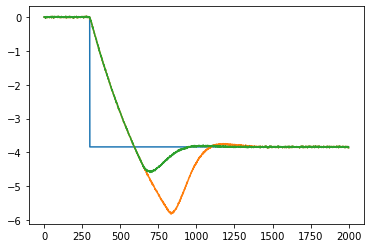

In [97]:
print(costinit)
print(costinitback)
plt.figure()
plt.plot(refs[16,:])
plt.plot(yinit[16,:])
plt.plot(yinitback[16,:])
#plt.plot(uinit[16,:])

In [102]:
# Initialize network
Tft = torch.tensor(Tf,requires_grad=True)
kpit = torch.tensor(kp,requires_grad=False)
kiit = torch.tensor(ki,requires_grad=False)
#kdit = torch.tensor(kd,requires_grad=False)
backit = torch.tensor(back,requires_grad=False)

kpt = torch.tensor(kp,requires_grad=True)
kit = torch.tensor(ki,requires_grad=True)
#kdit = torch.tensor(kd,requires_grad=False)
backt = torch.tensor(back,requires_grad=True)

systA = torch.tensor(sysA,requires_grad=False)
systB = torch.tensor(sysB,requires_grad=False)
systC = torch.tensor(sysC,requires_grad=False)
systD = torch.tensor(sysD,requires_grad=False)

PIDparams = neuralPID()
#optimizer = torch.optim.Adam((PIDparams.parameters()), lr=0.1)
#for iters in range(1000):
#   kpt,kit,kdt = PIDparams(torch.randn(3,))
#   print(kpt,kit,kdt)
#   loss = (kpt-kpit)**2+(kit-kiit)**2+(kdt-kdit)**2
#   optimizer.zero_grad()
#   loss.backward()
#   optimizer.step()    
   #print(iters,loss) 

In [103]:
ysat = np.zeros((T,))
uvalssat = np.zeros((T,))

optimizer = torch.optim.Adam((PIDparams.parameters()), lr=0.1)
smooth = 0.9
dtlossvals = []
closs = 0

for episodes in range(301):
  #cepisode = np.random.randint(20)  
  cepisode = episodes%20  
  if(cepisode==0):  
    episodeorder = np.random.choice(20, 20, replace=False)
  ref = refs[episodeorder[cepisode],:]
  reft = torch.tensor(ref)  
  xcont = torch.tensor([0.0],requires_grad=True)
  x = torch.tensor([[0.0]],requires_grad=True)  
  u = torch.tensor([0.0],requires_grad=True)
  ucmd = torch.tensor([0.0],requires_grad=True)
  cost = torch.tensor([0.0],requires_grad=True)
  yt = torch.tensor([0.0],requires_grad=True)
  #D  = torch.tensor([0.0],requires_grad=False)
  #ad = torch.div(Tft,(Tft+0.01))
  noise = 0.01*torch.randn(T,1)
  kpt = kpt.clone().detach()
  kit = kit.clone().detach()
  backt = backt.clone().detach()
  for t in range(T):
    yold = yt
    yt = torch.matmul(systC.float(),x)+noise[t]
    saterr = u-ucmd
    err = reft[t]-yt
    ninput = torch.cat((err,saterr),0)
    kpdt,kidt,backdt = PIDparams(ninput)
    kpt = smooth*kpt+(1-smooth)*(kpit+kpdt)
    kit = smooth*kit+(1-smooth)*(kiit+kidt)
    backt = smooth*backit+(1-smooth)*(backit+backdt)
    xcont = xcont+kit*err+backt*saterr.detach()
    if(t>0):
      #bd = torch.div(kdt,(Tft+0.01))
      #D = ad*D-bd*(yt-yold);  
      ucmd = (0.01*xcont+kpt*(reft[t]-yt))
      u = torch.clamp(ucmd,-10.0,10.0)
    x = torch.matmul(systA.float(),x)+systB.float()*u;
    cost = cost+(reft[t]-yt)**2  
  
  closs = closs+cost  
  if(episodes%20==19):        
    dtlossvals.append(closs.clone().detach().numpy()[0]/20)
    closs = 0
    
  if(episodes%120<20):
    print(episodes,cost)
  optimizer.zero_grad()
  cost.backward()
  optimizer.step()                      

0 tensor([952.5483], grad_fn=<AddBackward0>)
1 tensor([842.0378], grad_fn=<AddBackward0>)
2 tensor([186.1527], grad_fn=<AddBackward0>)
3 tensor([191.7441], grad_fn=<AddBackward0>)
4 tensor([617.7554], grad_fn=<AddBackward0>)
5 tensor([190.4014], grad_fn=<AddBackward0>)
6 tensor([183.2953], grad_fn=<AddBackward0>)
7 tensor([722.2694], grad_fn=<AddBackward0>)
8 tensor([185.9828], grad_fn=<AddBackward0>)
9 tensor([182.2240], grad_fn=<AddBackward0>)
10 tensor([182.8649], grad_fn=<AddBackward0>)
11 tensor([181.6929], grad_fn=<AddBackward0>)
12 tensor([426.7221], grad_fn=<AddBackward0>)
13 tensor([1296.7690], grad_fn=<AddBackward0>)
14 tensor([245.7145], grad_fn=<AddBackward0>)
15 tensor([889.2316], grad_fn=<AddBackward0>)
16 tensor([176.1914], grad_fn=<AddBackward0>)
17 tensor([1148.2301], grad_fn=<AddBackward0>)
18 tensor([278.1846], grad_fn=<AddBackward0>)
19 tensor([174.8281], grad_fn=<AddBackward0>)
120 tensor([170.3147], grad_fn=<AddBackward0>)
121 tensor([171.6277], grad_fn=<AddBackwa

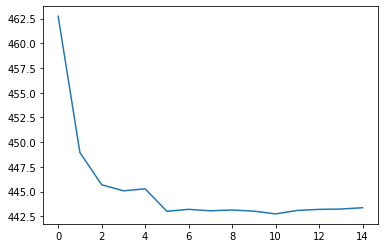

In [104]:
#plt.figure()
#plt.plot(ref)
plt.figure()
plt.plot(dtlossvals)
torch.save(PIDparams.state_dict(), "./datafiles/fodstablegradientparams")

In [108]:
kpst = torch.tensor(kp,requires_grad=True)
kist = torch.tensor(ki,requires_grad=True)
#kdst = torch.tensor(kd,requires_grad=True)
backst = torch.tensor(back,requires_grad=True)
#Tft = torch.tensor(Tf,requires_grad=True)
optimizer = torch.optim.Adam((kpst,kist,backst), lr=0.1)

stlossvals = []
closs = 0
kptrain = []
kitrain = []
kdtrain = []
backtrain = []
for episodes in range(301):
  cepisode = episodes%20  
  if(cepisode==0):  
    episodeorder = np.random.choice(20, 20, replace=False)
  ref = refs[episodeorder[cepisode],:]
  reft = torch.tensor(ref)  
  xcont = torch.tensor([0.0],requires_grad=True)
  x = torch.tensor([[0.0]],requires_grad=True)  
  ucmd = torch.tensor([0.0],requires_grad=True)
  u = torch.tensor([0.0],requires_grad=True)  
  cost = torch.tensor([0.0],requires_grad=True)
  yt = torch.tensor([0.0],requires_grad=True)
  D  = torch.tensor([0.0],requires_grad=False)
  #torch.clamp(Tft,0.1,0.1)
  #ad = torch.div(Tft,(Tft+0.01))
  #bd = torch.div(kdst,(Tft+0.01))
  noise = 0.01*torch.randn(T,1)
  
  for t in range(T):
    yold = yt
    yt = torch.matmul(systC.float(),x)+noise[t];
    #error = torch.tensor(reft[t]-yt,requires_grad=False)
    saterr = u-ucmd
    xcont = xcont+kist*(reft[t]-yt)+backst*saterr
    if(t>0):
       #deriv = torch.tensor(yt-yold,requires_grad=False) 
       #D = ad*D-bd*(yt-yold);  
       ucmd = (0.01*xcont+kpst*(reft[t]-yt))
    u = torch.clamp(ucmd,-10.0,10.0)
    uvalssat[i] = u;
    x = torch.matmul(systA.float(),x)+systB.float()*u;
    cost = cost+torch.clamp((reft[t]-yt)**2,0,50)
  closs = closs+cost  
  if(episodes%20==19):    
    stlossvals.append(closs.clone().detach().numpy()/20)
    closs = 0
  kptrain.append(kpst.clone().detach().numpy())
  kitrain.append(kist.clone().detach().numpy())
  #kdtrain.append(kdst.clone().detach().numpy())
  backtrain.append(backst.clone().detach().numpy())  
  if(episodes%120<20):
    #print(kpt,kdt,kit,Tft)
    print(episodes,cost,backst) 
  optimizer.zero_grad()
  cost.backward()
  optimizer.step()

print(kpst,kist,backst)

0 tensor([193.6184], grad_fn=<AddBackward0>) tensor(0.5000, requires_grad=True)
1 tensor([1187.1560], grad_fn=<AddBackward0>) tensor(0.6000, requires_grad=True)
2 tensor([186.0255], grad_fn=<AddBackward0>) tensor(0.6865, requires_grad=True)
3 tensor([252.8062], grad_fn=<AddBackward0>) tensor(0.7612, requires_grad=True)
4 tensor([423.8251], grad_fn=<AddBackward0>) tensor(0.8310, requires_grad=True)
5 tensor([181.6329], grad_fn=<AddBackward0>) tensor(0.9003, requires_grad=True)
6 tensor([579.0697], grad_fn=<AddBackward0>) tensor(0.9638, requires_grad=True)
7 tensor([179.1714], grad_fn=<AddBackward0>) tensor(1.0268, requires_grad=True)
8 tensor([177.9468], grad_fn=<AddBackward0>) tensor(1.0848, requires_grad=True)
9 tensor([279.2238], grad_fn=<AddBackward0>) tensor(1.1385, requires_grad=True)
10 tensor([879.0549], grad_fn=<AddBackward0>) tensor(1.1891, requires_grad=True)
11 tensor([176.7821], grad_fn=<AddBackward0>) tensor(1.2369, requires_grad=True)
12 tensor([175.8568], grad_fn=<AddBac

16.581871 11.071438 0.8712853


Text(0, 0.5, 'Back-calculation constant')

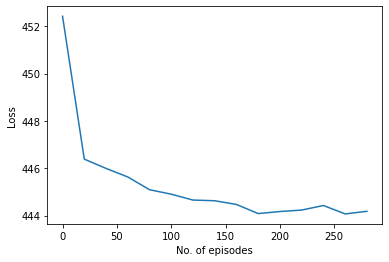

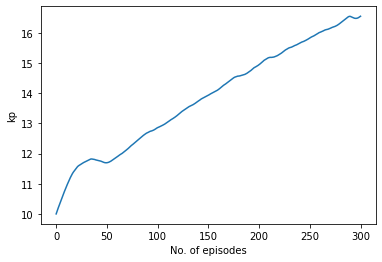

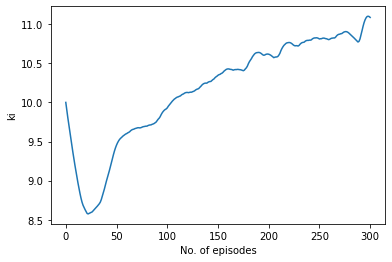

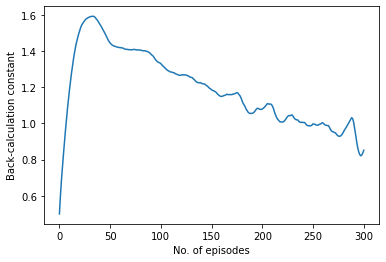

In [109]:
kps = kpst.detach().numpy()
kis = kist.detach().numpy()
#kds = kdst.detach().numpy()
backs = backst.detach().numpy()
print(kps,kis,backs)

plt.figure()
plt.plot(np.arange(len(stlossvals))*20,stlossvals)
plt.xlabel("No. of episodes")
plt.ylabel("Loss")

plt.figure()
plt.plot(np.arange(len(kptrain)),kptrain)
plt.xlabel("No. of episodes")
plt.ylabel("kp")

#plt.figure()
#plt.plot(np.arange(len(kdtrain)),kdtrain)
#plt.xlabel("No. of episodes")
#plt.ylabel("kd")

plt.figure()
plt.plot(np.arange(len(kitrain)),kitrain)
plt.xlabel("No. of episodes")
plt.ylabel("ki")

plt.figure()
plt.plot(np.arange(len(backtrain)),backtrain)
plt.xlabel("No. of episodes")
plt.ylabel("Back-calculation constant")

In [110]:
costdgradient = np.zeros((30,))
costinit = np.zeros((30,))
costbackinit = np.zeros((30,))
costsgradient = np.zeros((30,))
kpt = torch.tensor(kp,requires_grad=True)
kit = torch.tensor(ki,requires_grad=True)
#kdit = torch.tensor(kd,requires_grad=False)
backt = torch.tensor(back,requires_grad=True)

ydgradient = np.zeros((30,T))
udgradient = np.zeros((30,T))

ysgradient = np.zeros((30,T))
usgradient = np.zeros((30,T))
smooth = 0.9

kpdgradient = np.zeros((30,T))
kidgradient = np.zeros((30,T))
#kddgradient = np.zeros((10,T))
backdgradient = np.zeros((30,T))
#PIDparams = neuralPID()
#PIDparams.load_state_dict(torch.load("dgradientparams"))

yinit = np.zeros((30,T))
uinit = np.zeros((30,T))

for iters in range(0,30):
  ref = refs[iters,:]
  reft = torch.tensor(ref)
  noise = 0.01*torch.randn(T,1)  
  
  xcont = torch.tensor([0.0],requires_grad=True)
  x = torch.tensor([[0.0]],requires_grad=True)  
  u = torch.tensor([0.0],requires_grad=True)
  ucmd = torch.tensor([0.0],requires_grad=True)
  cost = torch.tensor([0.0],requires_grad=True)
  yt = torch.tensor([0.0],requires_grad=True)
#  D  = torch.tensor([0.0],requires_grad=False)
  #torch.clamp(Tft,0.1,0.1)
#  ad = torch.div(Tft,(Tft+0.01))
  
  for t in range(T):
    yold = yt
    yt = torch.matmul(systC.float(),x)+noise[t];
    ydgradient[iters,t] = yt.clone().detach().numpy()
    #print(yt)
    #error = torch.tensor(reft[t]-yt,requires_grad=False)
    saterr = u-ucmd
    err = reft[t]-yt
    ninput = torch.cat((err.detach(),saterr.detach()),0)
    kpdt,kidt,backdt = PIDparams(ninput)
    kpt = smooth*kpt+(1-smooth)*(kpit+kpdt)
    kit = smooth*kit+(1-smooth)*(kiit+kidt)
    backt = smooth*backit+(1-smooth)*(backit+backdt)
    xcont = xcont+kit*err+backt*saterr.detach()
    if(t>0):
#      bd = torch.div(kdt,(Tft+0.01))
#      D = ad*D-bd*(yt-yold);  
      ucmd = (0.01*xcont+kpt*(reft[t]-yt))
      u = torch.clamp(ucmd,-10.0,10.0)
      udgradient[iters,t] = u.clone().detach().numpy()
      kpdgradient[iters,t] = kpt.clone().detach().numpy()
      kidgradient[iters,t] = kit.clone().detach().numpy()
#      kddgradient[iters,t] = kdt.clone().detach().numpy()
      backdgradient[iters,t] = backt.clone().detach().numpy()  
    x = torch.matmul(systA.float(),x)+systB.float()*u;
    cost = cost+(reft[t]-yt)**2
    
  costdgradient[iters] = cost.detach().numpy()

  xcont = torch.tensor([0.0],requires_grad=True)
  x = torch.tensor([[0.0]],requires_grad=True)  
  u = torch.tensor([0.0],requires_grad=True)
  cost = torch.tensor([0.0],requires_grad=True)
  yt = torch.tensor([0.0],requires_grad=True)
  #D  = torch.tensor([0.0],requires_grad=False)
  #torch.clamp(Tft,0.1,0.1)
  #ad = torch.div(Tft,(Tft+0.01))
  
  for t in range(T):
    yold = yt
    yt = torch.matmul(systC.float(),x)+noise[t];
    yinit[iters,t] = yt.clone().detach().numpy()
    #print(yt)
    #error = torch.tensor(reft[t]-yt,requires_grad=False)
    err = ref[t]-yt
    xcont = xcont+err
    if(t>0):
       #print(t,kpt,kit,kdt)
       #break;
       #bd = torch.div(kdit,(Tft+0.01))
       #D = ad*D-bd*(yt-yold);  
       u = (0.01*kiit*xcont+kpit*(ref[t]-yt))
       u = torch.clamp(u,-10.0,10.0)
    uinit[iters,t] = u.clone().detach().numpy()
    x = torch.matmul(systA.float(),x)+systB.float()*u;
    cost = cost+(reft[t]-yt)**2
  costinit[iters] = cost.detach().numpy()

  xcont = torch.tensor([0.0],requires_grad=True)
  x = torch.tensor([[0.0]],requires_grad=True)  
  u = torch.tensor([0.0],requires_grad=True)
  ucmd = torch.tensor([0.0],requires_grad=True)  
  cost = torch.tensor([0.0],requires_grad=True)
  yt = torch.tensor([0.0],requires_grad=True)
  #D  = torch.tensor([0.0],requires_grad=False)
  #torch.clamp(Tft,0.1,0.1)
  #ad = torch.div(Tft,(Tft+0.01))
  
  for t in range(T):
    yold = yt
    yt = torch.matmul(systC.float(),x)+noise[t];
    yinitback[iters,t] = yt.clone().detach().numpy()
    #print(yt)
    #error = torch.tensor(reft[t]-yt,requires_grad=False)
    err = ref[t]-yt
    saterr = u-ucmd
    xcont = xcont+kiit*err+backit*saterr
    if(t>0):
       #print(t,kpt,kit,kdt)
       #break;
       #bd = torch.div(kdit,(Tft+0.01))
       #D = ad*D-bd*(yt-yold);  
       ucmd = (0.01*xcont+kpit*(ref[t]-yt))
       u = torch.clamp(ucmd,-10.0,10.0)
    uinitback[iters,t] = u.clone().detach().numpy()
    x = torch.matmul(systA.float(),x)+systB.float()*u;
    cost = cost+(reft[t]-yt)**2
  costinitback[iters] = cost.detach().numpy()

  xcont = torch.tensor([0.0],requires_grad=True)
  x = torch.tensor([[0.0]],requires_grad=True)  
  u = torch.tensor([0.0],requires_grad=True)
  ucmd = torch.tensor([0.0],requires_grad=True)    
  cost = torch.tensor([0.0],requires_grad=True)
  yt = torch.tensor([0.0],requires_grad=True)
  D  = torch.tensor([0.0],requires_grad=False)
  #torch.clamp(Tft,0.1,0.1)
  #ad = torch.div(Tft,(Tft+0.01))
  #bd = torch.div(kdst,(Tft+0.01))

  for t in range(T):
    yold = yt
    yt = torch.matmul(systC.float(),x)+noise[t];
    ysgradient[iters,t] = yt.clone().detach().numpy()
    #print(yt)
    #error = torch.tensor(reft[t]-yt,requires_grad=False)
    saterr = u-ucmd
    xcont = xcont+kist*(reft[t]-yt)+backst*saterr.detach()
    if(t>0):
       #deriv = torch.tensor(yt-yold,requires_grad=False) 
       #D = ad*D-bd*(yt-yold);  
       ucmd = (0.01*xcont+kpst*(reft[t]-yt))
    u = torch.clamp(ucmd,-10.0,10.0)
    usgradient[iters,t] = u.clone().detach().numpy()
    x = torch.matmul(systA.float(),x)+systB.float()*u;
    cost = cost+(reft[t]-yt)**2
  costsgradient[iters] = cost.detach().numpy() 

In [114]:
print("Dgradient-dynamic",costdgradient)
print("Dgradient-static",costsgradient)
print("Initial",costinit)
print("Initial-backcalculation",costinitback)

print("Dgradient-dynamic",np.mean(costdgradient[0:20]),np.std(costdgradient[0:20]))
print("Dgradient-static",np.mean(costsgradient[0:20]),np.std(costsgradient[0:20]))
print("Initial",np.mean(costinit[0:20]),np.std(costinit[0:20]))
print("Initial-backcalculation",np.mean(costinitback[0:20]),np.std(costinitback[0:20]))

print("Dgradient-dynamic",np.mean(costdgradient[20:30]),np.std(costdgradient[20:30]))
print("Dgradient-static",np.mean(costsgradient[20:30]),np.std(costsgradient[20:30]))
print("Initial",np.mean(costinit[20:30]),np.std(costinit[20:30]))
print("Initial-backcalculation",np.mean(costinitback[20:30]),np.std(costinitback[20:30]))

Dgradient-dynamic [ 172.23146057  172.72370911  172.15731812  172.37843323  171.68354797
  172.75041199  171.67666626  678.63745117 1141.16711426  170.95323181
  274.81106567  172.44786072  172.10191345  875.94610596  897.60046387
  796.86486816 1269.4708252   412.15805054  238.7046051   569.72637939
 1264.70471191  296.1086731   173.05337524  243.80999756  624.46081543
  171.57026672  507.07485962 1007.36767578  171.71672058  170.78607178]
Dgradient-static [ 172.70332336  173.1231842   172.75302124  173.01725769  173.00492859
  173.22631836  172.77671814  677.7923584  1139.99731445  172.27571106
  275.17953491  172.89929199  172.55108643  874.44610596  897.46606445
  797.75921631 1269.73168945  411.7984314   238.86412048  568.66986084
 1263.03100586  296.17056274  174.0221405   244.25071716  625.95080566
  172.46221924  507.7272644  1005.32263184  172.57217407  172.28251648]
Initial [ 225.31347656  225.59648132  225.3993988   225.78089905  225.74769592
  225.85754395  225.32763672 100

Text(0, 0.5, 'Back-calculation gain')

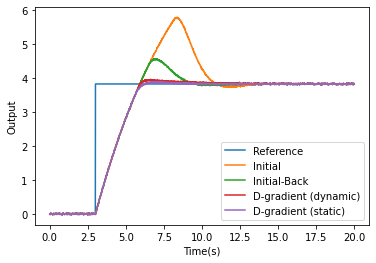

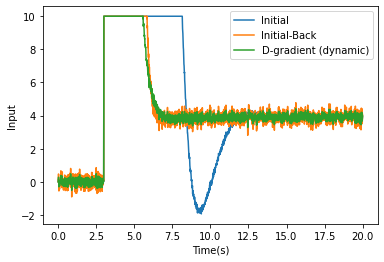

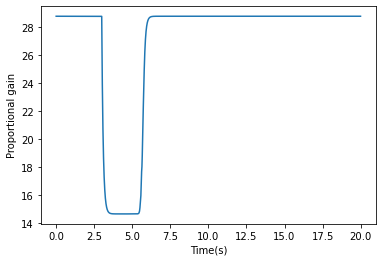

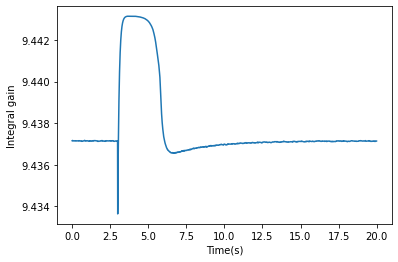

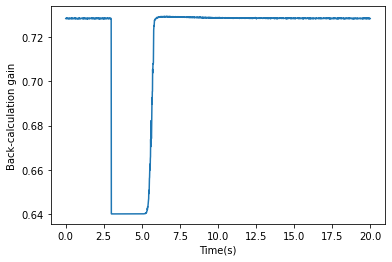

In [115]:
plt.figure()
plt.plot(0.01*np.arange(0,T),refs[20,:])
plt.plot(0.01*np.arange(0,T),yinit[20,:])
plt.plot(0.01*np.arange(0,T),yinitback[20,:])
plt.plot(0.01*np.arange(0,T),ydgradient[20,:])
plt.plot(0.01*np.arange(0,T),ysgradient[20,:])
plt.xlabel("Time(s)")
plt.ylabel("Output")
plt.legend(["Reference","Initial","Initial-Back","D-gradient (dynamic)","D-gradient (static)"])

plt.figure()
plt.plot(0.01*np.arange(0,T),uinit[20,:])
plt.plot(0.01*np.arange(0,T),udgradient[20,:])
plt.plot(0.01*np.arange(0,T),usgradient[20,:])
plt.xlabel("Time(s)")
plt.ylabel("Input")
plt.legend(["Initial","Initial-Back","D-gradient (dynamic)","D-gradient (static)"])

plt.figure()
plt.plot(0.01*np.arange(1,T),kpdgradient[20,1:])
plt.xlabel("Time(s)")
plt.ylabel("Proportional gain")

plt.figure()
plt.plot(0.01*np.arange(1,T),kidgradient[20,1:])
plt.xlabel("Time(s)")
plt.ylabel("Integral gain")

#plt.figure()
#plt.plot(0.01*np.arange(1,T),kddgradient[2,1:])
#plt.xlabel("Time(s)")
#plt.ylabel("Derivative gain")

plt.figure()
plt.plot(0.01*np.arange(1,T),backdgradient[20,1:])
plt.xlabel("Time(s)")
plt.ylabel("Back-calculation gain")

In [120]:
np.save("./datafiles/foddstabledtlossvals",dtlossvals)
np.save("./datafiles/foddstablestlossvals",stlossvals)
np.save("./datafiles/foddstableydgradient",ydgradient)
np.save("./datafiles/foddstableysgradient",ysgradient)
np.save("./datafiles/foddstableyinit",yinit)
np.save("./datafiles/foddstableyinitback",yinitback)
np.save("./datafiles/foddstableudgradient",udgradient)
np.save("./datafiles/foddstableusgradient",usgradient)
np.save("./datafiles/foddstableuinit",uinit)
np.save("./datafiles/foddstableuinitback",uinitback)
np.save("./datafiles/foddstablekpdgradient",kpdgradient)
np.save("./datafiles/foddstablekidgradient",kidgradient)
np.save("./datafiles/foddstablebackdgradient",backdgradient)
np.save("./datafiles/foddstablekptrain",kptrain)
np.save("./datafiles/foddstablekitrain",kitrain)
np.save("./datafiles/foddstablebacktrain",backtrain)
np.save("./datafiles/foddstablerefs",refs)
np.save("./datafiles/foddstablecostdgradient",costdgradient)
np.save("./datafiles/foddstablecostsgradient",costsgradient)
np.save("./datafiles/foddstablecostinit",costinit)
np.save("./datafiles/foddstablecostinitback",costinitback)

In [17]:
 # Load and generate all plots

In [122]:
dtlossvals = np.load("./datafiles/foddstabledtlossvals.npy")
stlossvals = np.load("./datafiles/foddstablestlossvals.npy")
ydgradient = np.load("./datafiles/foddstableydgradient.npy")
ysgradient = np.load("./datafiles/foddstableysgradient.npy")
yinit = np.load("./datafiles/foddstableyinit.npy")
yinitback = np.load("./datafiles/foddstableyinitback.npy")
udgradient = np.load("./datafiles/foddstableudgradient.npy")
usgradient = np.load("./datafiles/foddstableusgradient.npy")
uinit = np.load("./datafiles/foddstableuinit.npy")
uinitback = np.load("./datafiles/foddstableuinitback.npy")
kpdgradient = np.load("./datafiles/foddstablekpdgradient.npy")
kidgradient = np.load("./datafiles/foddstablekidgradient.npy")
backdgradient = np.load("./datafiles/foddstablebackdgradient.npy")
kptrain = np.load("./datafiles/foddstablekptrain.npy")
kitrain = np.load("./datafiles/foddstablekitrain.npy")
backtrain = np.load("./datafiles/foddstablebacktrain.npy")
refs = np.load("./datafiles/foddstablerefs.npy")
costdgradient = np.load("./datafiles/foddstablecostdgradient.npy")
costsgradient = np.load("./datafiles/foddstablecostsgradient.npy")
costinit = np.load("./datafiles/foddstablecostinit.npy")
costinitback = np.load("./datafiles/foddstablecostinitback.npy")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


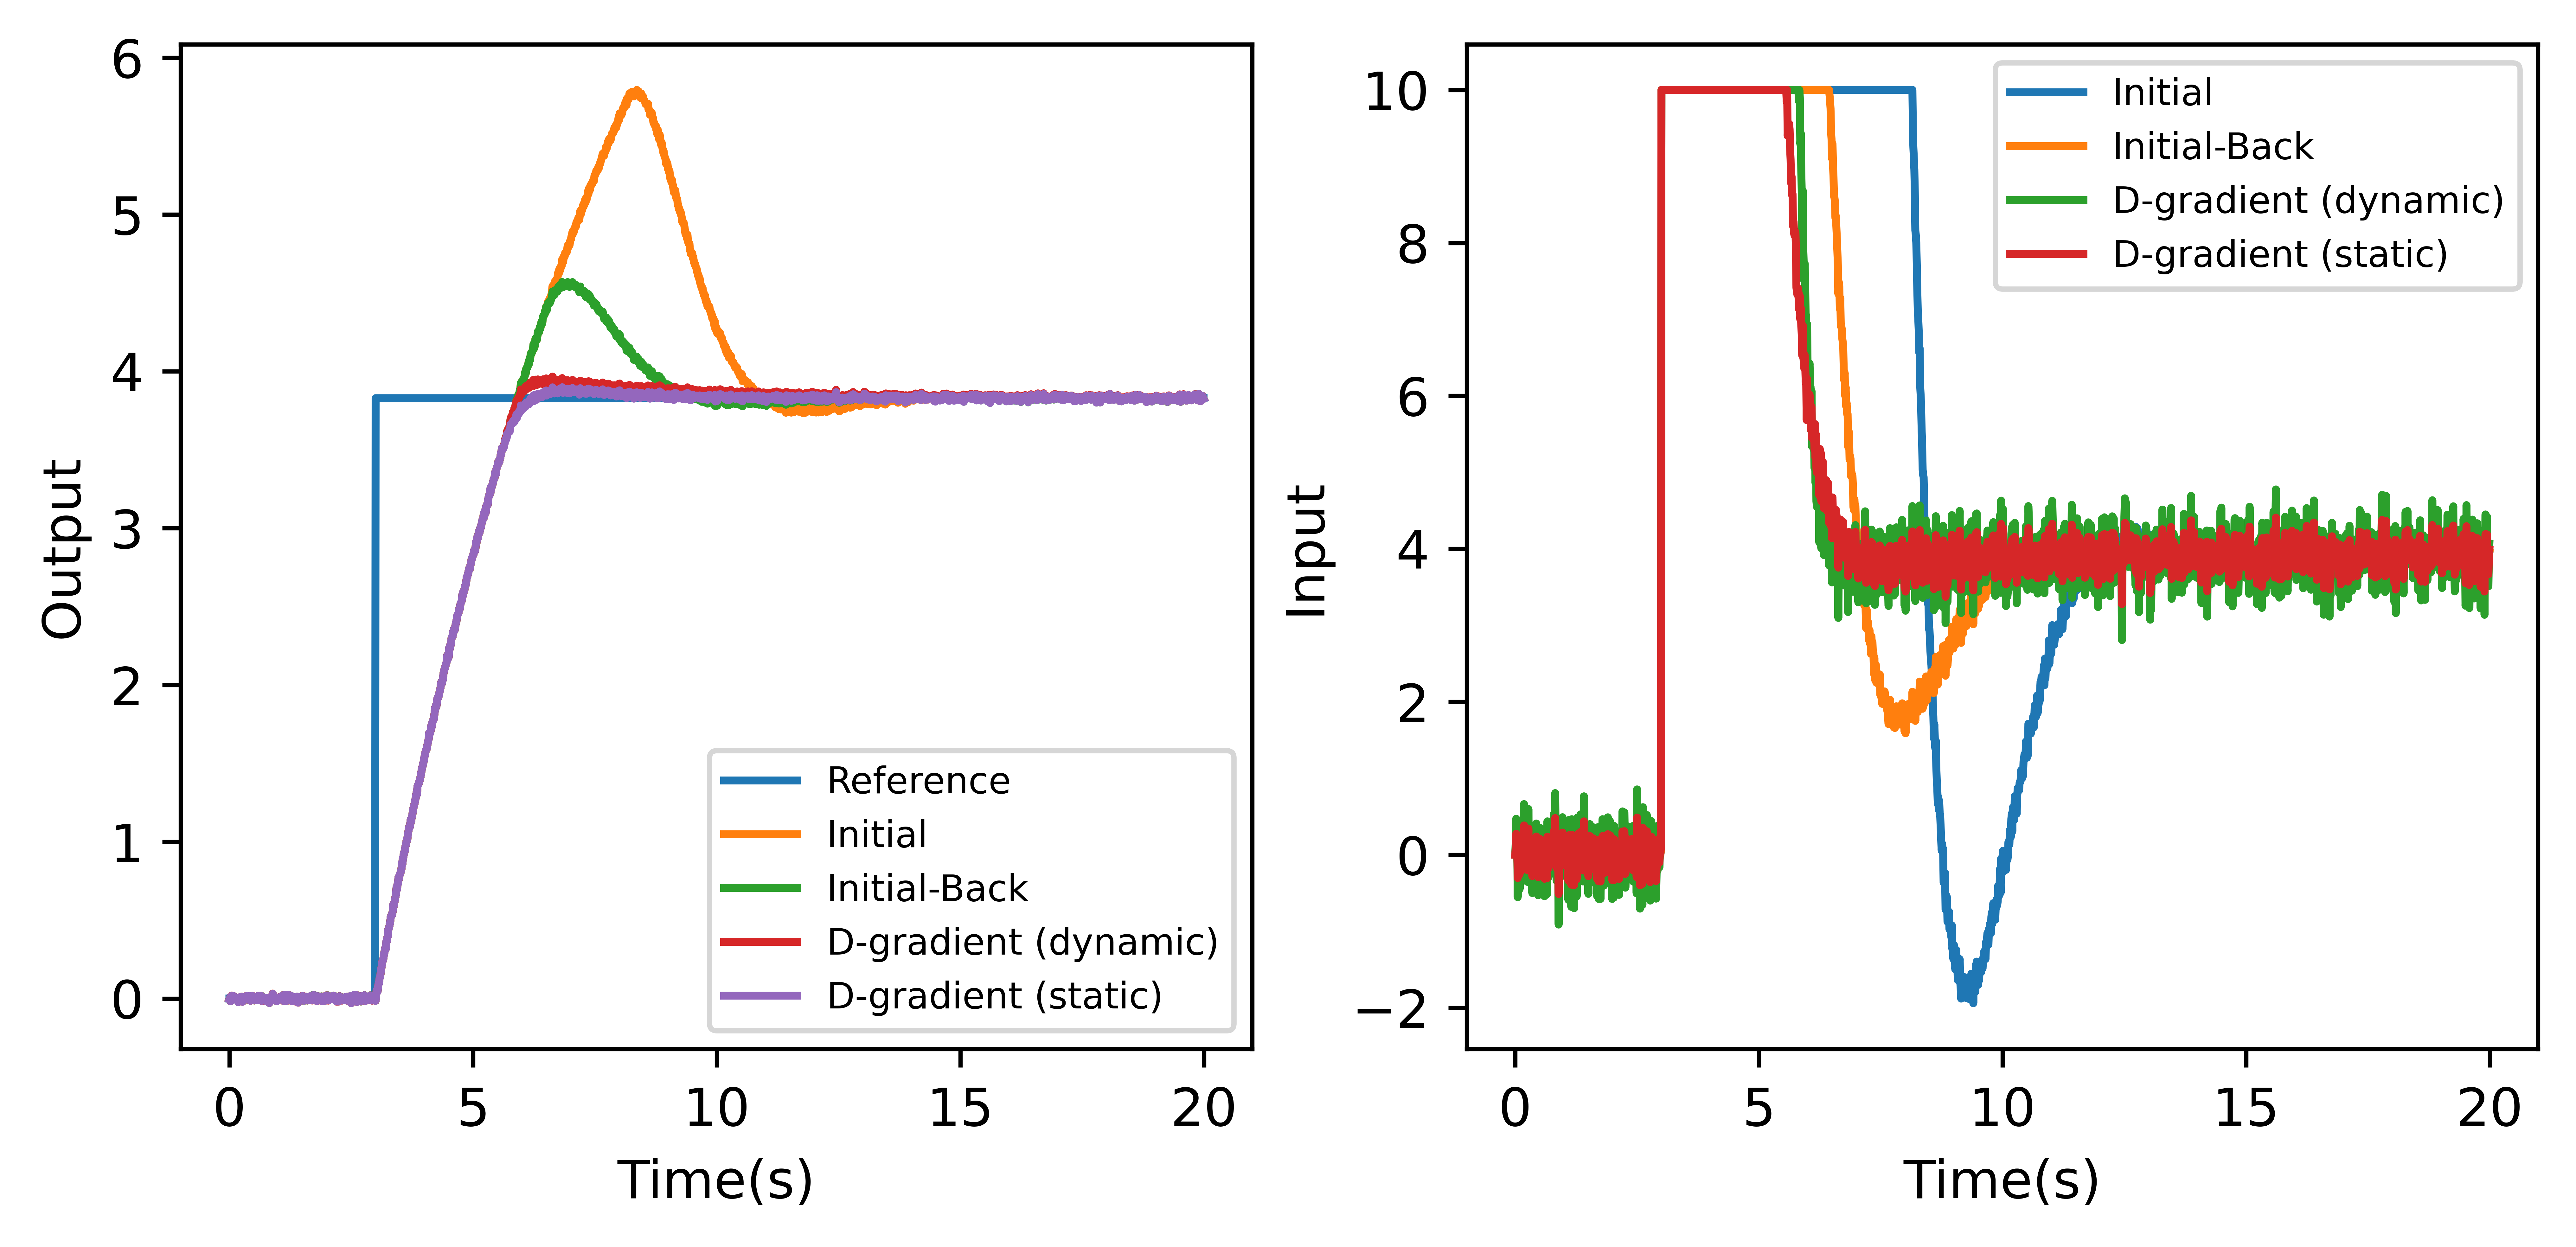

In [159]:
plt.figure(dpi=1200,figsize=[8.0,3.5])
plt.subplot(1,2,1)
plt.plot(0.01*np.arange(0,T),refs[20,:])
plt.plot(0.01*np.arange(0,T),yinit[20,:])
plt.plot(0.01*np.arange(0,T),yinitback[20,:])
plt.plot(0.01*np.arange(0,T),ydgradient[20,:])
plt.plot(0.01*np.arange(0,T),ysgradient[20,:])
plt.xlabel("Time(s)")
plt.ylabel("Output")
plt.legend(["Reference","Initial","Initial-Back","D-gradient (dynamic)","D-gradient (static)"],fontsize="x-small")

plt.subplot(1,2,2)
plt.plot(0.01*np.arange(0,T),uinit[20,:])
plt.plot(0.01*np.arange(0,T),uinitback[20,:])
plt.plot(0.01*np.arange(0,T),udgradient[20,:])
plt.plot(0.01*np.arange(0,T),usgradient[20,:])
plt.xlabel("Time(s)")
plt.ylabel("Input")
plt.legend(["Initial","Initial-Back","D-gradient (dynamic)","D-gradient (static)"],fontsize="x-small")
plt.savefig("./figures/foddstable1.eps", facecolor='w', dpi=1200, edgecolor='b',orientation='portrait', format="eps", bbox_inches=tr.Bbox([[0,0],[8.0,3.5]]), 
            pad_inches=0.1)
plt.figure(dpi=1200,figsize=[15.0,5.0])
plt.subplot(1,3,1)
plt.plot(0.01*np.arange(1,T),kpdgradient[20,1:])
plt.xlabel("Time(s)")
plt.ylabel("Proportional gain")

plt.subplot(1,3,2)
plt.plot(0.01*np.arange(1,T),kidgradient[20,1:])
plt.xlabel("Time(s)")
plt.ylabel("Integral gain")

#plt.figure()
#plt.plot(0.01*np.arange(1,T),kddgradient[2,1:])
#plt.xlabel("Time(s)")
#plt.ylabel("Derivative gain")

plt.subplot(1,3,3)
plt.plot(0.01*np.arange(1,T),backdgradient[20,1:])
plt.xlabel("Time(s)")
plt.ylabel("Back-calculation gain")
plt.savefig("./figures/foddstable2.eps", facecolor='w', dpi=1200, edgecolor='b',orientation='portrait', format="eps", bbox_inches=tr.Bbox([[0,0],[15.0,5.0]]), 
            pad_inches=0.1)